In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [2]:
import os
import sys
import time
import json
import glob
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from pytorch3d.structures import Volumes
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    VolumeRenderer,
    NDCGridRaysampler,
    EmissionAbsorptionRaymarcher
)
from pytorch3d.transforms import so3_exp_map

from plot_image_grid import image_grid
from generate_cow_renders import generate_cow_renders

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [4]:
target_cameras, target_images, target_silhouettes = generate_cow_renders(num_views=120)

In [5]:
render_size = 128
volume_extent_world = 3.0

raysampler = NDCGridRaysampler(
    image_width=render_size,
    image_height=render_size,
    n_pts_per_ray=150,
    min_depth=0.1,
    max_depth=volume_extent_world,
)

raymarcher = EmissionAbsorptionRaymarcher()
renderer = VolumeRenderer(
    raysampler=raysampler, raymarcher=raymarcher,
)


In [6]:
class VolumeModel(torch.nn.Module):
    def __init__(self, renderer, volume_size=[64] * 3, voxel_size=0.1):
        super().__init__()
        self.log_densities = torch.nn.Parameter(-4.0 * torch.ones(1, *volume_size))
        self.log_colors = torch.nn.Parameter(torch.zeros(3, *volume_size))
        self._voxel_size = voxel_size
        self._renderer = renderer

    def forward(self, cameras):
        batch_size = cameras.R.shape[0]

        densities = torch.sigmoid(self.log_densities)
        colors = torch.sigmoid(self.log_colors)

        volumes = Volumes(
            densities=densities[None].expand(
                batch_size, *self.log_densities.shape),
            features=colors[None].expand(
                batch_size, *self.log_colors.shape),
            voxel_size=self._voxel_size,
        )
        return self._renderer(cameras=cameras, volumes=volumes)[0]


In [7]:
def huber(x, y, scaling=0.1):
    diff_sq = (x - y) ** 2
    loss = ((1 + diff_sq / (scaling ** 2)).clamp(1e-4).sqrt() - 1) * float(scaling)
    return loss

In [8]:
target_cameras = target_cameras.to(device)
target_images = target_images.to(device)
target_silhouettes = target_silhouettes.to(device)

volume_size = 128
volume_model = VolumeModel(
    renderer,
    volume_size=[volume_size] * 3,
    voxel_size=volume_extent_world / volume_size,
).to(device)


In [9]:

lr = 0.1
optimizer = torch.optim.Adam(volume_model.parameters(), lr=lr)

batch_size = 10
n_iter = 300
for iteration in range(n_iter):

    if iteration == round(n_iter * 0.75):
        print('Decreasing LR 10-fold ...')
        optimizer = torch.optim.Adam(
            volume_model.parameters(), lr=lr * 0.1
        )

    optimizer.zero_grad()
    batch_idx = torch.randperm(len(target_cameras))[:batch_size]

    # Sample the minibatch of cameras.
    batch_cameras = FoVPerspectiveCameras(
        R=target_cameras.R[batch_idx],
        T=target_cameras.T[batch_idx],
        znear=target_cameras.znear[batch_idx],
        zfar=target_cameras.zfar[batch_idx],
        aspect_ratio=target_cameras.aspect_ratio[batch_idx],
        fov=target_cameras.fov[batch_idx],
        device=device,
    )

    rendered_images, rendered_silhouettes = volume_model(
        batch_cameras
    ).split([3, 1], dim=-1)

    sil_err = huber(
        rendered_silhouettes[..., 0], target_silhouettes[batch_idx],
    ).abs().mean()

    color_err = huber(
        rendered_images, target_images[batch_idx],
    ).abs().mean()

    loss = color_err + sil_err
    if iteration % 10 == 0:
        print(
            f'Iteration {iteration:05d}:'
            + f' color_err = {float(color_err):1.2e}'
            + f' mask_err = {float(sil_err):1.2e}'
        )

    # Take the optimization step.
    loss.backward()
    optimizer.step()

Iteration 00000: color_err = 2.68e-01 mask_err = 5.69e-01
Iteration 00010: color_err = 1.12e-01 mask_err = 3.56e-01
Iteration 00020: color_err = 3.73e-02 mask_err = 1.83e-01
Iteration 00030: color_err = 1.39e-02 mask_err = 8.37e-02
Iteration 00040: color_err = 1.00e-02 mask_err = 4.93e-02
Iteration 00050: color_err = 7.77e-03 mask_err = 3.19e-02
Iteration 00060: color_err = 6.82e-03 mask_err = 2.44e-02
Iteration 00070: color_err = 5.94e-03 mask_err = 2.13e-02
Iteration 00080: color_err = 5.41e-03 mask_err = 1.76e-02
Iteration 00090: color_err = 5.44e-03 mask_err = 1.77e-02
Iteration 00100: color_err = 5.10e-03 mask_err = 1.48e-02
Iteration 00110: color_err = 5.43e-03 mask_err = 1.50e-02
Iteration 00120: color_err = 5.09e-03 mask_err = 1.31e-02
Iteration 00130: color_err = 4.67e-03 mask_err = 1.28e-02
Iteration 00140: color_err = 4.33e-03 mask_err = 1.19e-02
Iteration 00150: color_err = 4.45e-03 mask_err = 1.14e-02
Iteration 00160: color_err = 4.83e-03 mask_err = 1.26e-02
Iteration 0017

Generating rotating volume ...


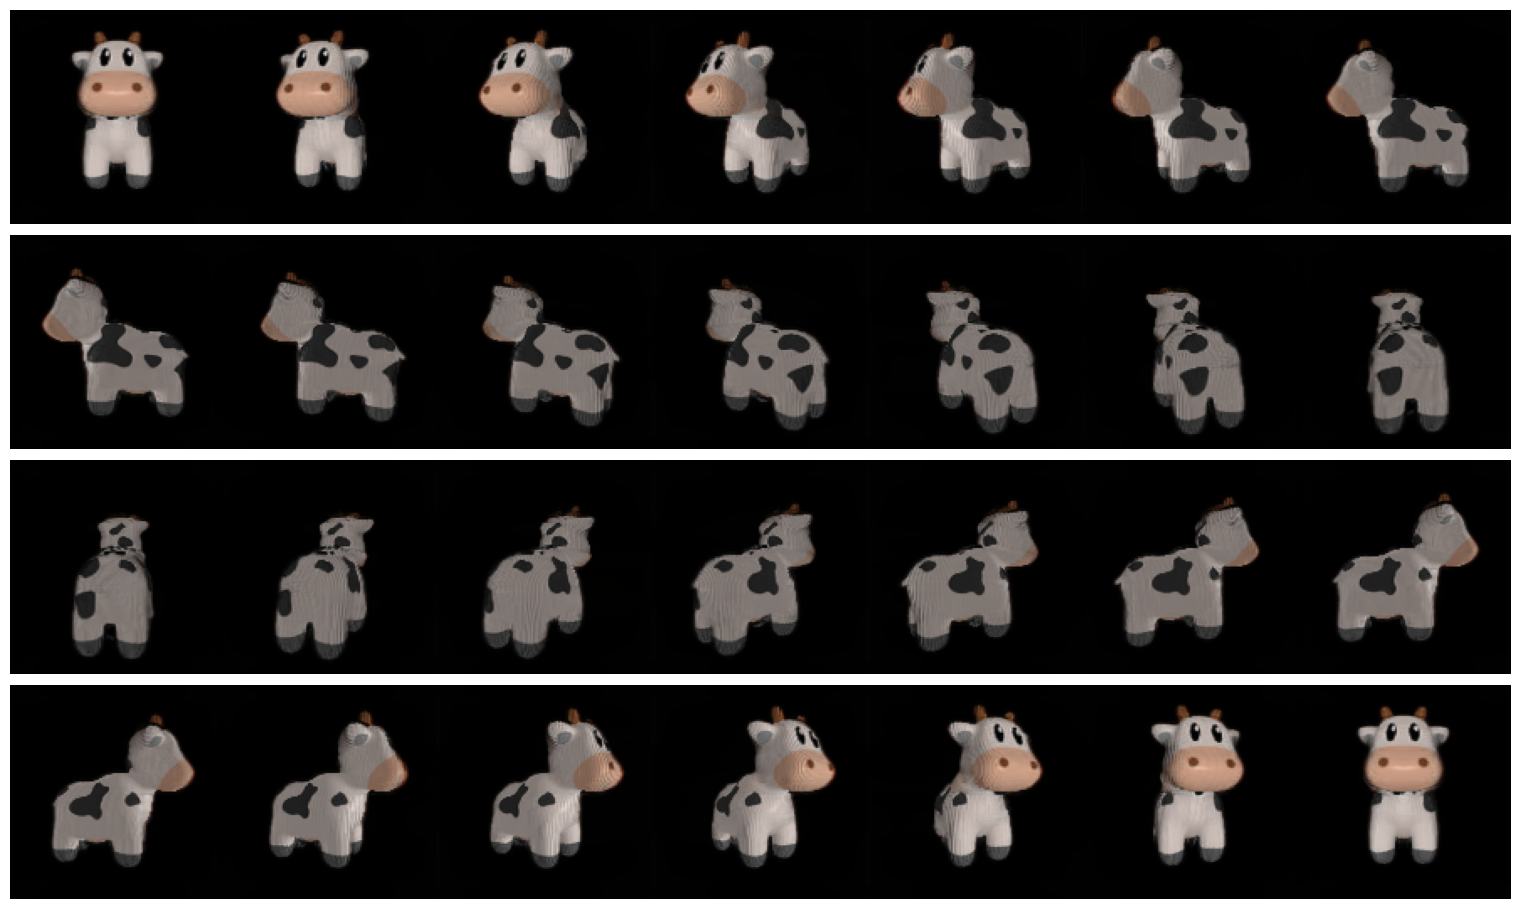

In [10]:
def generate_rotating_volume(volume_model, n_frames=50):
    logRs = torch.zeros(n_frames, 3, device=device)
    logRs[:, 1] = torch.linspace(0.0, 2.0 * 3.14, n_frames, device=device)
    Rs = so3_exp_map(logRs)
    Ts = torch.zeros(n_frames, 3, device=device)
    Ts[:, 2] = 2.7
    frames = []
    print('Generating rotating volume ...')
    for R, T in zip(Rs, Ts):
        camera = FoVPerspectiveCameras(
            R=R[None],
            T=T[None],
            znear=target_cameras.znear[0],
            zfar=target_cameras.zfar[0],
            aspect_ratio=target_cameras.aspect_ratio[0],
            fov=target_cameras.fov[0],
            device=device,
        )
        frames.append(volume_model(camera)[..., :3].clamp(0.0, 1.0))
    return torch.cat(frames)


with torch.no_grad():
    rotating_volume_frames = generate_rotating_volume(volume_model, n_frames=7 * 4)

image_grid(rotating_volume_frames.clamp(0., 1.).cpu().numpy(), rows=4, cols=7, rgb=True, fill=True)
plt.savefig('rotating_volume.png')
plt.show()


In [11]:
XX,YY,ZZ=np.meshgrid(np.linspace(-1,1,volume_size),np.linspace(-1,1,volume_size),np.linspace(0.1,volume_extent_world,volume_size))

In [12]:
grid_points=np.vstack((XX.reshape(-1),YY.reshape(-1),ZZ.reshape(-1))).T

In [13]:
colors=torch.sigmoid(volume_model.log_colors).permute(1,2,3,0).detach().cpu().numpy().reshape(-1,3)

In [14]:
densities=(torch.sigmoid(volume_model.log_densities).permute(1,2,3,0).detach().cpu().numpy()>=0.5).reshape(-1)

In [15]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [16]:
pip install open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 111.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.3 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.9.2
    Uninstalling nbformat-5.9.2:
      Successfully uninstalled n

In [17]:
import open3d as o3d

In [18]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(grid_points[densities==1])
pcd.colors = o3d.utility.Vector3dVector(colors[densities==1])
o3d.io.write_point_cloud('volume.ply',pcd)

True

In [19]:
import plotly.graph_objects as go

In [20]:
X,Y,Z=grid_points[densities==1].T

In [21]:
R,G,B=colors[densities==1].T

In [22]:
fig = go.Figure(
    data=[
        go.Scatter3d(x=X,
                      y=Z,
                      z=Y,
                      mode='markers',
                      marker=dict(size=5,
                                  color=['rgb({},{},{})'.format(r,g,b) for r,g,b in zip(R,G,B)],
                                  opacity=0.9,))
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.show()